In [ ]:
import six
import numpy as np
import tensorflow.compat.v2 as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras

In [ ]:
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape + (1,)).astype("float32")
    x_test = x_test.reshape(x_test.shape + (1,)).astype("float32")

    x_train /= 256.0
    x_test /= 256.0

    x_mean = np.mean(x_train, axis=0)

    x_train -= x_mean
    x_test -= x_mean

    nb_classes = np.max(y_train)+1
    y_train = to_categorical(y_train, nb_classes)
    y_test = to_categorical(y_test, nb_classes)

    #quantizer = quantized_bits(9, 1)
    #x_train = quantizer(x_train)
    #x_test = quantizer(x_test)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = get_data()

# **Making own activation**

To implement: max(α(x+c)−c, min(α(x−c)+c, x))

In [ ]:
class MyActivation(keras.layers.Layer):

    #def __init__(self):
    #    super(MyActivation, self).__init__()
    #    self.a = self.add_weight(
    #        shape=(1), initializer="zeros", trainable=True
    #    )
    #    self.c = self.add_weight(shape=(1), initializer="zeros", trainable=True)

    def __init__(self, **kwargs):
        super(MyActivation, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.a = self.add_weight(name='a',
                                      shape=(1),
                                      initializer ='ones',  # TODO: Choose your initializer
                                      trainable=True)
        self.c = self.add_weight(name='c',
                                      shape=(1),
                                      initializer='ones',  # TODO: Choose your initializer
                                      trainable=True)
        super(MyActivation, self).build(input_shape)

    def call(self, x):
        #return tf.matmul(inputs, self.w) + self.b
        return K.maximum(self.a*(x + self.c), K.minimum(self.a*(x - self.c) + self.c, x))
        #return K.maximum(K.zeros_like(x), x)

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
from keras import backend as K
def swish(x, beta=10.0):
    #return x * K.sigmoid(beta * x)
    return K.switch(K.less(x, 0), self.a*K.zeros_like(x), x)

In [ ]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = Flatten(name="flatten")(x)
    x = Dense(256,
        name="dense")(x)
    #x = Activation('relu')(x)
    x = MyActivation()(x)
    x = Dense(128,
        name="dense2")(x)
    x = MyActivation()(x)
    x = Dense(128,
        name="dense3")(x)
    x = MyActivation()(x)
    x = Dense(nb_classes,
        name="dense4")(x)
    x = Activation("softmax", name="softmax")(x)

    model = Model(inputs=x_in, outputs=x)    
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)

model = CreateModel(x_train.shape[1:], y_train.shape[-1])
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.0005),
    #optimizer='sgd',
    metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test[:5000], y_test[:5000]), verbose=False, callbacks=[callback])



In [ ]:
model.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 0s 2ms/step - loss: 0.2196 - accuracy: 0.9392


[0.2195868343114853, 0.9391999840736389]

In [ ]:
model.get_weights()[10]

array([1.0112158], dtype=float32)

In [ ]:
model.layers

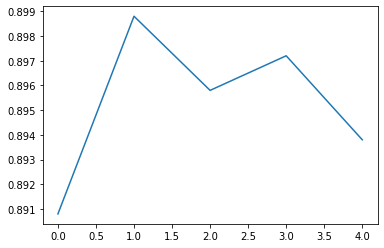

In [ ]:
%matplotlib inline
plt.plot(history.history['val_accuracy'])